In [11]:
import tensorflow as tf 
%matplotlib inline 
import matplotlib.pylab as plt
import numpy as np
from google_images_download import google_images_download

# task: classifcation cars
 * firebrigades
 * police cars
 * rescue cars

### Load images

In [6]:
resp = google_images_download.googleimagesdownload()

config_fire = {
    "keywords":"Feuerwehr Auto",
    "limit": 30,
    "print_urls": True, 
    "output_directory":"images",
    "image_directory":"fire"
}

config_police = {
    "keywords":"Polizei Fahrzeug",
    "limit": 30,
    "print_urls": True, 
    "output_directory":"images",
    "image_directory":"police"
}

config_rescue = {
    "keywords":"Rettungs Auto",
    "limit": 30,
    "print_urls": True, 
    "output_directory":"images",
    "image_directory":"rescue"
}

paths  = resp.download(config_fire)
print(paths)
paths  = resp.download(config_police)
print(paths)
paths  = resp.download(config_rescue)
print(paths)



/image.kurier.at/images/cfs_landscape_616w_347h/3125389/2018121220pi20amstetten2c20foto201.jpg
Completed Image ====> 2.2018121220pi20amstetten2c20foto201.jpg
Image URL: https://intax.de/system/html/015_Suzuki%20Grand%20Vitara%20II%20ab%202012%20Polizeifahrzeug%20rechte%20Seite%202%202013-09-20-064ee026.jpg
Completed Image ====> 3.015_Suzuki%20Grand%20Vitara%20II%20ab%202012%20Polizeifahrzeug%20rechte%20Seite%202%202013-09-20-064ee026.jpg
Image URL: https://image.stern.de/7791460/16x9-620-349/8ade88a38a9ed554ab837b33eccd3e60/YI/surivor-polizei-sachsen.jpg
Completed Image ====> 4.surivor-polizei-sachsen.jpg
Image URL: https://cdn.pixabay.com/photo/2017/08/23/09/41/police-2672054_960_720.jpg
Completed Image ====> 5.police-2672054_960_720.jpg
Image URL: https://www.polizei.hessen.de/File/seitenansicht-des-bmw-530xd-touring.jpg?size=4
Completed Image ====> 6.seitenansicht-des-bmw-530xd-touring.jpg
Image URL: https://www.news-on-tour.de/wp-content/uploads/2016/01/polizeiauto_ntoi_polizei-obe

### Generator

In [7]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False
)

In [8]:
train_dir = './images'

IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size  = 32 

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))


Found 89 images belonging to 3 classes.


### found classes 

In [9]:
print(train_data_gen.class_indices)

{'fire': 0, 'police': 1, 'rescue': 2}


### display samples from training set


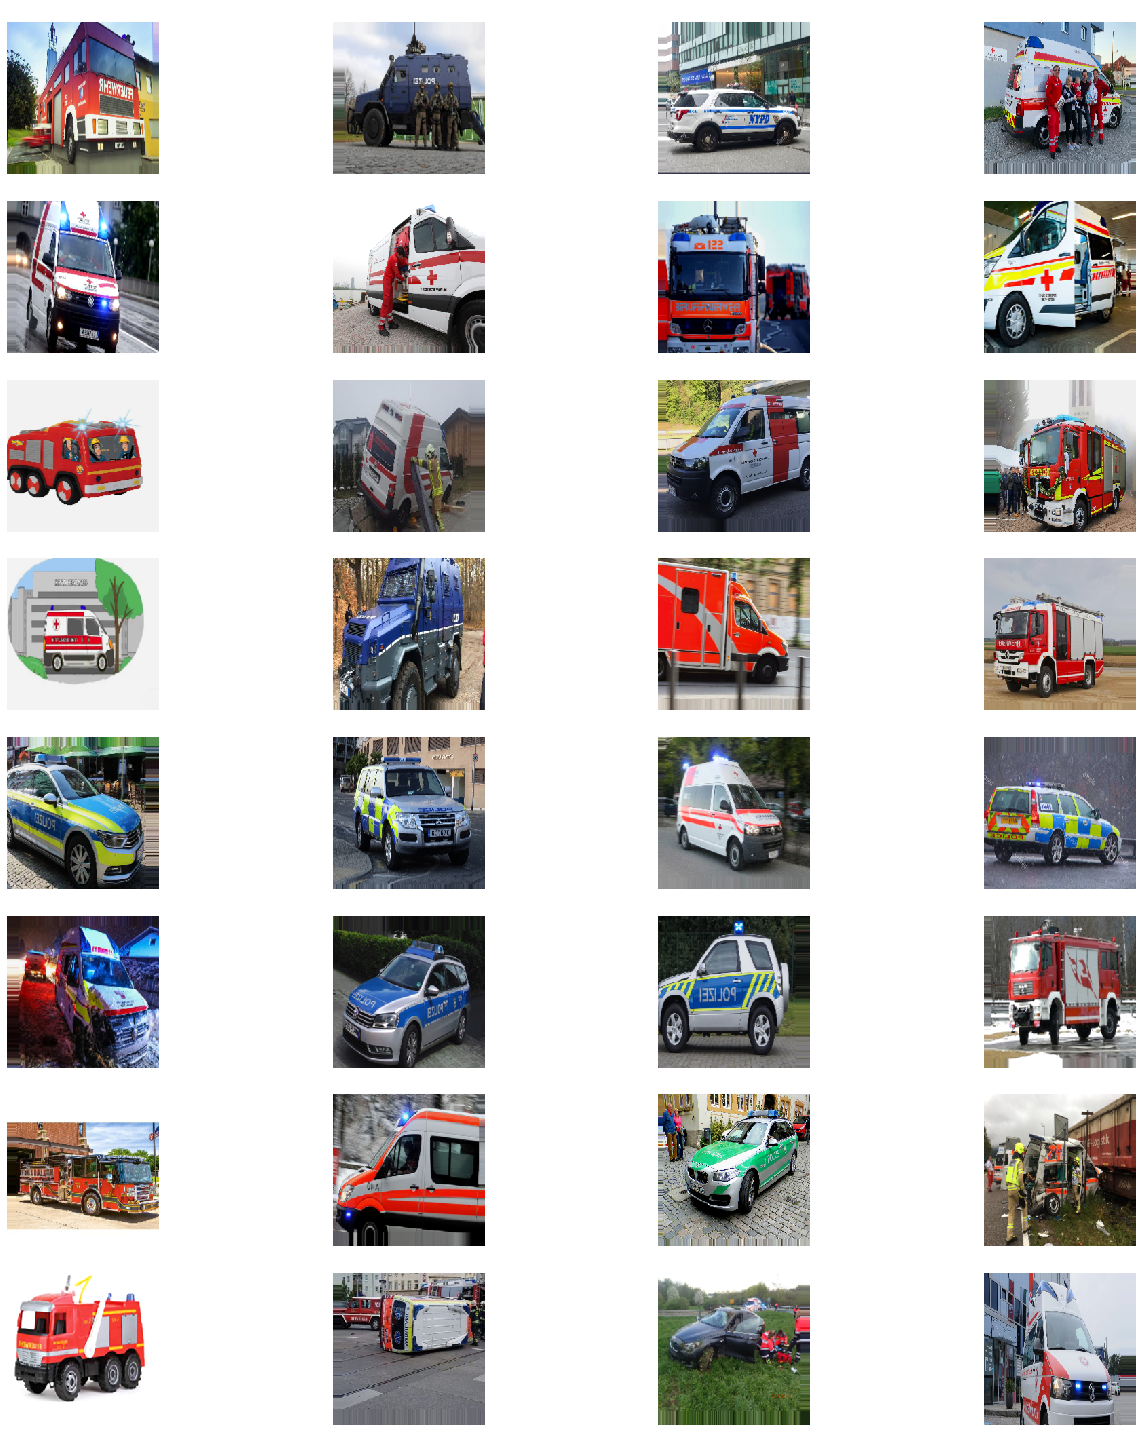

In [12]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

### pre-trained modelling

In [13]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])
    
model.summary()

94674944/94668760 [==============================] - 25s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 24,745,987
Trainable params: 24,700,547
Non-trainable params: 45,440
_________________________________________________________________


## helper function

In [14]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

In [ ]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

## only fully connected layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=2, #use way more steps here: number of samples / batch size
    epochs=3, #use way more or use EarlyStopping callback
    callbacks=[snapshot_callback]
)

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
model.save('cars.h5')

* test the data
*  calculate accuracy 